In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, k=10):
        super(Decoder, self).__init__()
        self.k = k
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W * k)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = self.fc_probs(x)
        probs = probs.view(probs.shape[0], IMG_H * IMG_W, self.k)
        probs = torch.softmax(probs, dim=-1)
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        cate_dist = torch.distributions.categorical.Categorical(probs_x)
        x_recon = cate_dist.sample() / (self.decoder.k - 1)
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [5]:
LATENT_DIM = 16
NUM_BINS = 4

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C, k=NUM_BINS)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:08<02:36,  8.23s/it]

Epoch 1, Mean Training ELBO 38244.03325, Mean Validation ELBO 38202.10623125


 10%|█         | 2/20 [00:14<02:09,  7.19s/it]

Epoch 2, Mean Training ELBO 38154.369355, Mean Validation ELBO 38128.0109375


 15%|█▌        | 3/20 [00:21<01:56,  6.84s/it]

Epoch 3, Mean Training ELBO 38113.072785, Mean Validation ELBO 38108.76333125


 20%|██        | 4/20 [00:27<01:47,  6.70s/it]

Epoch 4, Mean Training ELBO 38097.79804, Mean Validation ELBO 38094.0236625


 25%|██▌       | 5/20 [00:34<01:39,  6.64s/it]

Epoch 5, Mean Training ELBO 38089.01972, Mean Validation ELBO 38091.74851875


 30%|███       | 6/20 [00:40<01:32,  6.58s/it]

Epoch 6, Mean Training ELBO 38083.786085, Mean Validation ELBO 38084.654825


 35%|███▌      | 7/20 [00:47<01:25,  6.56s/it]

Epoch 7, Mean Training ELBO 38079.520145, Mean Validation ELBO 38085.238325


 40%|████      | 8/20 [00:53<01:18,  6.54s/it]

Epoch 8, Mean Training ELBO 38076.73877, Mean Validation ELBO 38081.31420625


 45%|████▌     | 9/20 [01:00<01:11,  6.52s/it]

Epoch 9, Mean Training ELBO 38073.651925, Mean Validation ELBO 38080.4250625


 50%|█████     | 10/20 [01:06<01:05,  6.53s/it]

Epoch 10, Mean Training ELBO 38071.53097, Mean Validation ELBO 38078.49520625


 55%|█████▌    | 11/20 [01:13<00:58,  6.52s/it]

Epoch 11, Mean Training ELBO 38070.317085, Mean Validation ELBO 38076.344575


 60%|██████    | 12/20 [01:19<00:52,  6.51s/it]

Epoch 12, Mean Training ELBO 38068.070695, Mean Validation ELBO 38076.4688


 65%|██████▌   | 13/20 [01:26<00:45,  6.52s/it]

Epoch 13, Mean Training ELBO 38067.147025, Mean Validation ELBO 38073.06729375


 70%|███████   | 14/20 [01:32<00:39,  6.52s/it]

Epoch 14, Mean Training ELBO 38065.42287, Mean Validation ELBO 38074.4606125


 75%|███████▌  | 15/20 [01:39<00:32,  6.52s/it]

Epoch 15, Mean Training ELBO 38064.578705, Mean Validation ELBO 38075.9663


 80%|████████  | 16/20 [01:45<00:26,  6.53s/it]

Epoch 16, Mean Training ELBO 38063.94814, Mean Validation ELBO 38072.38065625


 85%|████████▌ | 17/20 [01:52<00:19,  6.52s/it]

Epoch 17, Mean Training ELBO 38062.575425, Mean Validation ELBO 38075.39003125


 90%|█████████ | 18/20 [01:58<00:13,  6.53s/it]

Epoch 18, Mean Training ELBO 38061.91491, Mean Validation ELBO 38071.47061875


 95%|█████████▌| 19/20 [02:05<00:06,  6.54s/it]

Epoch 19, Mean Training ELBO 38061.471605, Mean Validation ELBO 38070.9088125


100%|██████████| 20/20 [02:11<00:00,  6.59s/it]

Epoch 20, Mean Training ELBO 38060.29771, Mean Validation ELBO 38073.7502375


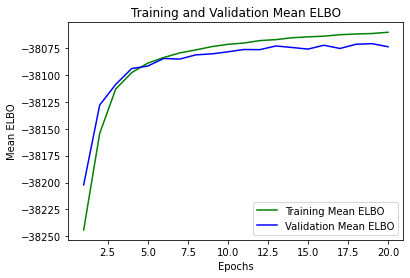

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            x = torch.clamp(torch.round(x * NUM_BINS), min=0, max=NUM_BINS - 1)
            x = F.one_hot(x.long())
            log_p = torch.sum(torch.log(probs_x * x + 1e-7))
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                x = torch.clamp(torch.round(x * NUM_BINS), min=0, max=NUM_BINS - 1)
                x = F.one_hot(x.long())
                log_p = torch.sum(torch.log(probs_x * x + 1e-7))
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(-mean_train_elbo)
        val_elbos.append(-mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean ELBO')
    plt.title('Training and Validation Mean ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean ELBO')
    plt.legend()
    plt.savefig('elbo_2c.png')
    plt.show()
train_vae(num_epochs=20)

In [7]:
torch.save(vae.state_dict(), 'state_dict_t2c.pt')

In [8]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        x_recon = vae.reconstruct(probs_x)
        return x, x_recon
test_batch, test_batch_recon = test_vae()

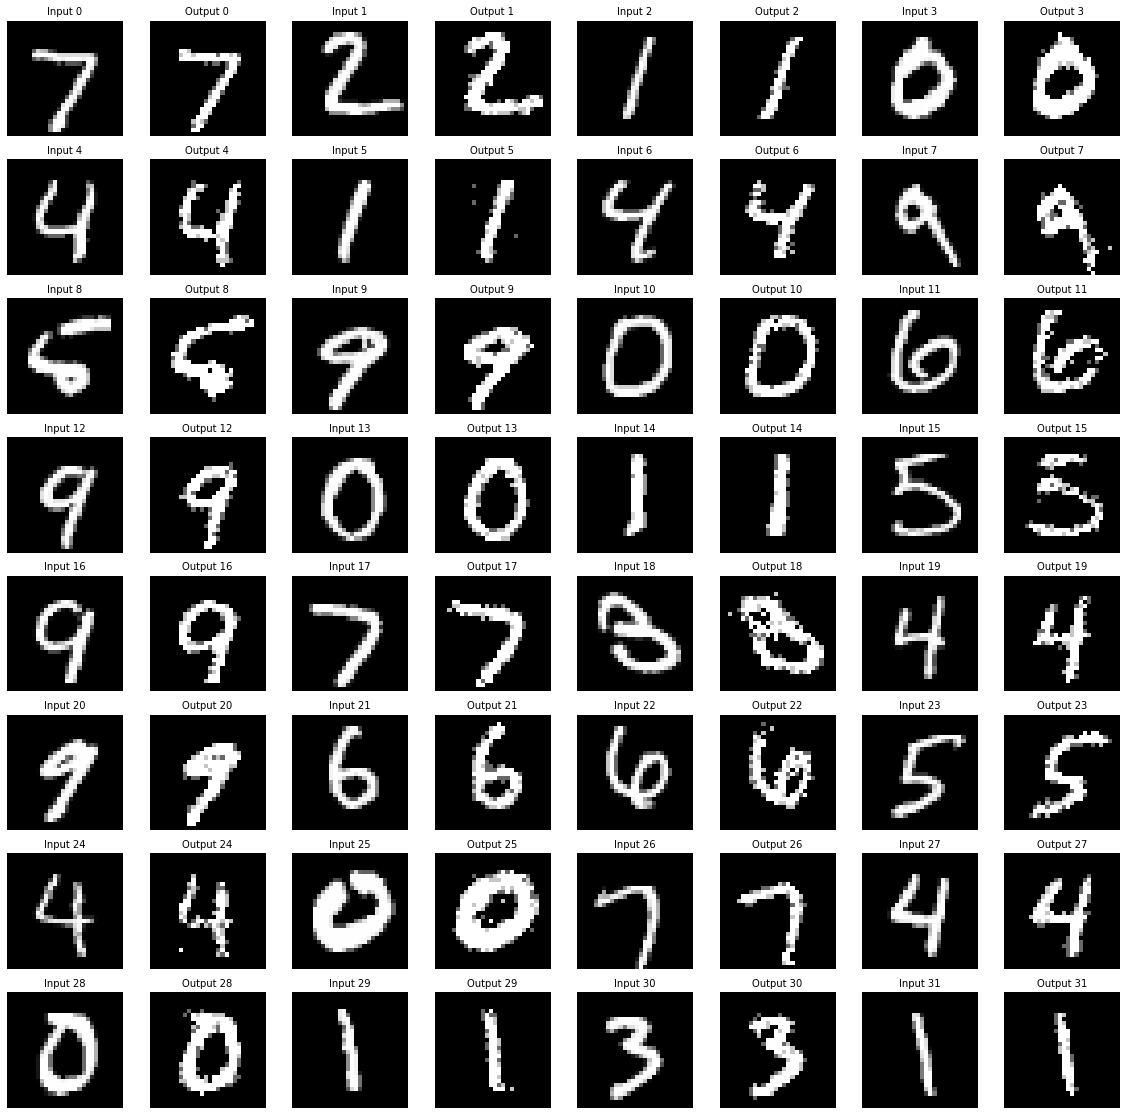

In [9]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], IMG_H, IMG_W)
    x_recon = x_recon.view(x_recon.shape[0], IMG_H, IMG_W)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
    plt.savefig('reconstructions_2c.png')
show_images(test_batch, test_batch_recon)

In [10]:
def sample_images(num_samples):
    with torch.no_grad():
        z = torch.randn((num_samples, LATENT_DIM)).to(DEVICE)
        probs_x = decoder(z)
        x_samples = vae.reconstruct(probs_x)
        return x_samples
samples = sample_images(num_samples=16)

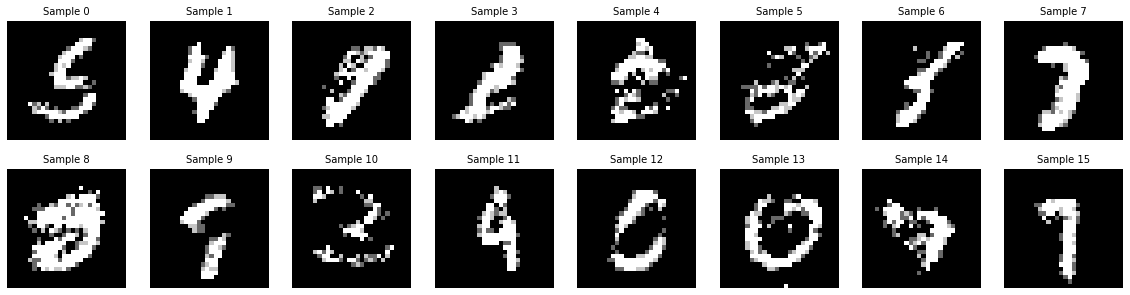

In [11]:
def show_samples(x):
    x = x.view(x.shape[0], 28, 28)
    fig, ax = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(2):
        for j in range(8):
            ax[i][j].imshow(x[i*8+j].cpu().numpy(), cmap="Greys_r")
            ax[i][j].set_title(f"Sample {i*8+j}", fontsize=10)
            ax[i][j].axis('off')
    plt.savefig('samples_2c.png')
show_samples(samples)